# Exploring chained multipoles to mitigate the effect of fiber collisions
(idea from G.-B. Zhao et al. 2021 https://doi.org/10.1093/mnras/stab849)

In [12]:
import os
import sys

import numpy as np
from matplotlib import pyplot as plt
from scipy.special import legendre

sys.path.append('../bin')
from utils import load_poles, load_poles_list
from cov_utils import get_EZmocks_covariance
from desi_file_manager import DESIFileName
from local_file_manager import LocalFileName

# plotting
plt.style.use(os.path.join(os.path.abspath('../bin'), 'plot_style.mplstyle'))
plots_dir = '../../plots/'

### Global parameters

In [16]:
# tracer
tracer = 'ELG'
region = 'GCcomb'
zrange = (1.1, 1.6)

# mocks/version
version = 'v4_1'
imocks = range(25)

# multipoles
ells = (0, 2)

fn = DESIFileName()
fn.set_default_config(version=version, tracer=tracer, region=region, baseline=False, weighting='_default_FKP_lin', nran=18, cellsize=6, boxsize=9000)
fn.update(zrange=zrange)

## Load mock power spectrum

In [17]:
fn.set_default_config(completeness=False, version=version).update(zrange=zrange)
poles = load_poles_list([fn.get_path(realization=imock) for imock in imocks], rebin=5)

fn.set_default_config(completeness=True, version=version).update(zrange=zrange)
poles_complete = load_poles_list([fn.get_path(realization=imock) for imock in imocks], rebin=5)

## Chained multipoles

In [18]:
def chained_poles(poles, ells):
    qk = [poles[i] - (2*ell+1) * legendre(ell)(0) / ((2*ell+5)  * legendre(ell+2)(0)) * poles[i+1] for i, ell in enumerate(ells)]
    return qk

In [19]:
qk_altmtl = chained_poles(poles['data'], ells)
qk_complete = chained_poles(poles_complete['data'], ells)

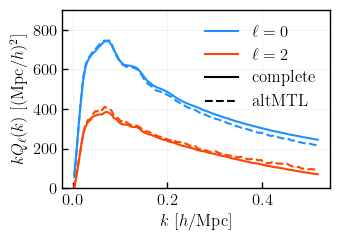

In [54]:
plt.figure(figsize=(3.5, 2.5))

ax = plt.gca()
k = poles['k'][i]
for i, ell in enumerate(ells):
    ax.plot(k, k * qk_altmtl[i], ls='--', color='C{}'.format(i))
    ax.plot(k, k * qk_complete[i], label=r'$\ell = {:d}$'.format(ell), color='C{}'.format(i))
    #ax.plot(k, k * poles_complete['data'][i], ls='-', color='C{}'.format(i), alpha=0.3)
    #ax.plot(k, k * poles['data'][i], ls='--', color='C{}'.format(i), alpha=0.3)
plt.plot([], [], ls='-', label=r'complete', color='black')
plt.plot([], [], ls='--', label=r'altMTL', color='black')
#plt.plot([], [], ls='-', label=r'$kP_{\ell}(k)$ (complete)', color='black', alpha=0.3)
#plt.plot([], [], ls='--', label=r'$kP_{\ell}(k)$ (f. a.)', color='black', alpha=0.3)
plt.legend()
plt.ylim(0, 900)
plt.xlabel(r'$k$  [$h$/Mpc]')
plt.ylabel(r'$kQ_{\ell}(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.savefig(os.path.join(plots_dir, version, 'chained_multipoles_{}_{}_25mocks.pdf'.format(tracer, region)), dpi=300)
plt.show()

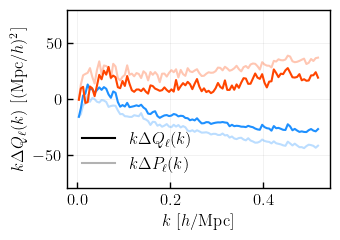

In [55]:
plt.figure(figsize=(3.5, 2.5))
ax = plt.gca()
for i, ell in enumerate(ells):
    ax.plot(k, k * (qk_altmtl[i] - qk_complete[i]), ls='-', color='C{}'.format(i))
    ax.plot(k, k * (poles['data'][i] - poles_complete['data'][i]), ls='-', color='C{}'.format(i), alpha=0.3)
plt.plot([], [], ls='-', label=r'$k \Delta Q_{\ell}(k)$', color='black')
plt.plot([], [], ls='-', label=r'$k \Delta P_{\ell}(k)$', color='black', alpha=0.3)
plt.legend()
plt.ylim(-80, 80)
plt.xlabel(r'$k$  [$h$/Mpc]')
plt.ylabel(r'$k \Delta Q_{\ell}(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.savefig(os.path.join(plots_dir, version, 'chained_multipoles_{}_{}_25mocks_delta_altmtl_complete.pdf'.format(tracer, region)), dpi=300)
plt.show()

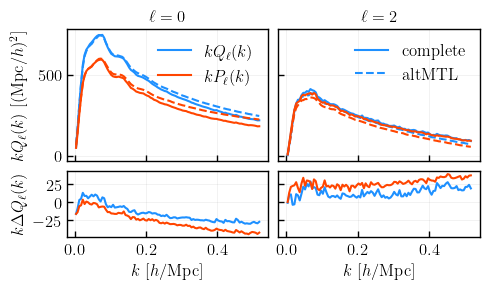

In [61]:
plt.rcParams["figure.autolayout"] = False
fig, axes = plt.subplots(2, 2, figsize=(5, 3), sharey='row', sharex=True, gridspec_kw={'height_ratios': [4, 2]})

for i, ell in enumerate(ells):
    axes[0][i].plot(k, k * qk_altmtl[i], color='C0', ls='-', label=r'$k Q_{\ell}(k)$' if i==0 else '')
    axes[0][i].plot(k, k * qk_complete[i], color='C0', ls='--')
    axes[0][i].plot(k, k * poles['data'][i], color='C1', ls='-', label=r'$k P_{\ell}(k)$' if i==0 else '')
    axes[0][i].plot(k, k * poles_complete['data'][i], color='C1', ls='--')
    axes[1][i].plot(k, k * (qk_altmtl[i] - qk_complete[i]), color='C0', ls='-')
    axes[1][i].plot(k, k * (poles['data'][i] - poles_complete['data'][i]), color='C1', ls='-')

axes[0][0].set_ylabel(r'$k Q_{\ell}(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
axes[1][0].set_ylabel(r'$k \Delta Q_{\ell}(k)$')

for i, ell in enumerate(ells):
    axes[1][i].set_xlabel(r'$k$  [$h$/Mpc]')
    axes[0][i].set_title(r'$\ell={}$'.format(ell))

axes[0][1].plot([], [], ls='-', label='complete', color='C0')
axes[0][1].plot([], [], ls='--', label='altMTL', color='C0')
    
axes[0][0].legend()
axes[0][1].legend()
fig.align_ylabels()
plt.tight_layout()
plt.subplots_adjust(wspace=0.05, hspace=0.1)
plt.savefig(os.path.join(plots_dir, version, 'chained_pk_multipoles_{}_{}_25mocks_delta_altmtl_complete.pdf'.format(tracer, region)), dpi=300)
plt.show()